# Image Recognition

### Project Work
by Cornelia Mayer, Maximilian Bauer, Julia Putz

## Import necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt

import os

## Data preperation

In [2]:
train_dir = './input/training/training/'
val_dir = './input/validation/validation/'

monkey_labels = pd.read_csv("./input/monkey_labels.txt")
num_classes = monkey_labels['Label'].size
monkey_labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


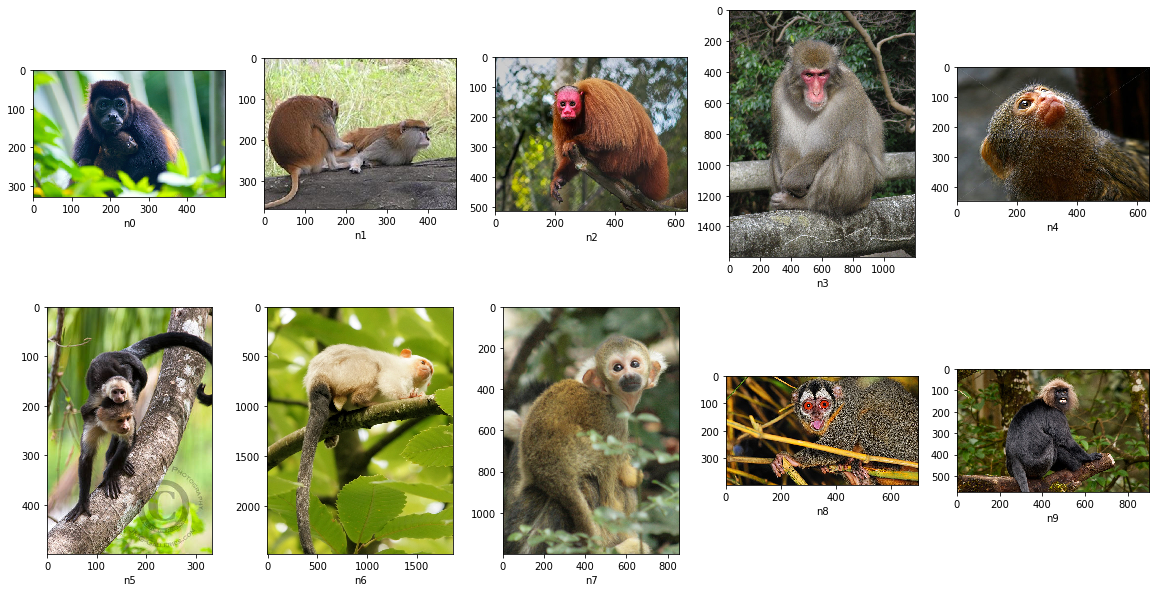

In [3]:
#print one monkey per species
%matplotlib inline

plt.figure(figsize=(20, 10))  #Abstand zw. Bildern
for i in range(10):
        plt.subplot(2, 5, i+1)  #(Zeilen, Abstand, )
        class_name = 'n' + str(i)
        plt.imshow(plt.imread('./input/validation/validation/' + class_name + '/' + class_name + '00.jpg'))
        plt.xlabel(class_name)

## Data modelling
using ResNet50

In [4]:
#create the base model out of a pretrained model

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

monkey_model = Sequential()
monkey_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
monkey_model.add(Dense(num_classes, activation='softmax'))

monkey_model.layers[0].trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
monkey_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
monkey_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
#Data Augemnetation improve accuracy of model - dadurch Datensatz aufblasen
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                             rotation_range = 30,
                                             zoom_range = 0.2,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2)
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [7]:
#fine tuning the model
image_size = 224 #because default input of ResNet50 is 224x224

train_generator = data_generator_with_aug.flow_from_directory(
       directory = train_dir,
       target_size=(image_size, image_size),
       batch_size=100,
       class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = val_dir,
       target_size=(image_size, image_size),
       class_mode='categorical')

ResNet50Model = monkey_model.fit_generator(
        train_generator,
        steps_per_epoch=80,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=1)


Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Epoch 1/5
45/45 [==============================] - 2255s 50s/step - loss: 1.5089 - acc: 0.5632 - val_loss: 0.5453 - val_acc: 0.8750
Epoch 2/5
45/45 [==============================] - 2964s 66s/step - loss: 0.5771 - acc: 0.9134 - val_loss: 0.2648 - val_acc: 0.9375
Epoch 3/5
45/45 [==============================] - 3126s 69s/step - loss: 0.3752 - acc: 0.9412 - val_loss: 0.1822 - val_acc: 0.9375
Epoch 4/5
45/45 [==============================] - 2997s 67s/step - loss: 0.2888 - acc: 0.9532 - val_loss: 0.1651 - val_acc: 0.9375
Epoch 5/5
45/45 [==============================] - 3014s 67s/step - loss: 0.2347 - acc: 0.9662 - val_loss: 0.1487 - val_acc: 0.9375


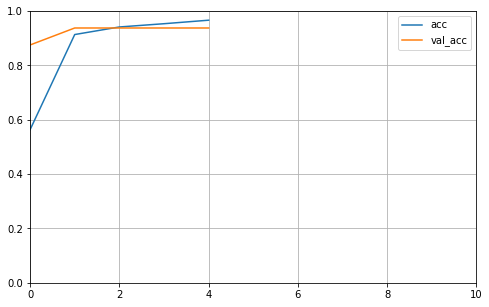

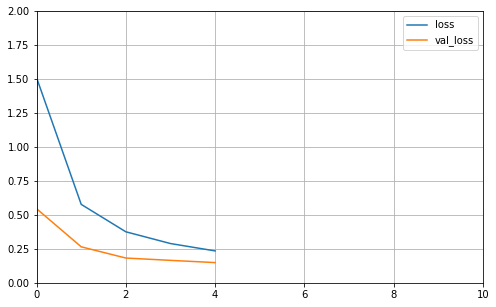

In [8]:
##plot curve to see the learning process of the model

epochs = 10
def plot_learning_curves(ResNet50Model, label, epochs, min_value, max_value):
    data = {}
    data[label] = ResNet50Model.history[label]
    data['val_'+label] = ResNet50Model.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(ResNet50Model, 'acc', epochs, 0, 1)
plot_learning_curves(ResNet50Model, 'loss', epochs, 0, 2)

## monkey prediction

In [9]:
from tensorflow.python.keras.preprocessing import image

def find_max_value(preds, labels):
    pos = np.argmax(preds)
    return labels.iloc[pos, 0], labels.iloc[pos, 2]

def predict(monkey_model, img_path, labels, target_size=(224, 224), top_n=5):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = monkey_model.predict(x)
    return find_max_value(preds, labels)


In [10]:
#get accuracy of the model by comparing the correct answers with predicted answers
from sklearn.metrics import accuracy_score
import re

test_labels = validation_generator.classes
prediction_labels = []

for i in range(10):
        class_name = 'n' + str(i)
        for j in os.listdir('./input/validation/validation/' + class_name):
            preds = predict(monkey_model, ('./input/validation/validation/' + class_name + '/' + j), monkey_labels)
            prediction = "".join(re.split("['n ']*", preds[0]))  
            prediction_labels.append(prediction)
    
prediction_labels = [int(x) for x in prediction_labels]

num_correct = 0
for i in range(len(prediction_labels)):
    if prediction_labels[i] == test_labels[i]:
        num_correct += 1
        
print(prediction_labels)
print(num_correct / len(test_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 7, 8, 7, 7, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 7, 7, 7, 8, 7, 8, 8, 9, 9, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9]
0.9411764705882353


predict monkey species for a specific monkey

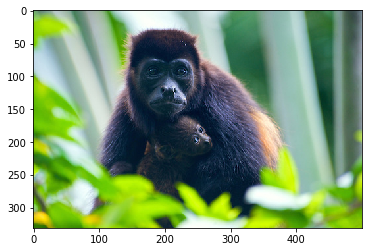

This monkey is a mantled_howler                


In [11]:
monkey = plt.imread('./input/validation/validation/n0/n000.jpg')
img_path = './input/validation/validation/n0/n000.jpg'

plt.figure()
plt.imshow(monkey)
plt.show()

pred = predict(monkey_model, img_path, monkey_labels)
print(f'This monkey is a{pred[1]}')

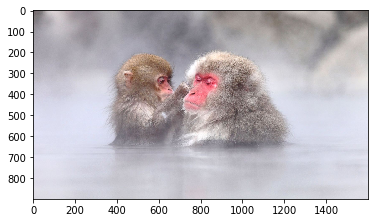

This monkey is a japanese_macaque              


In [12]:
monkey = plt.imread('./input/validation/validation/n3/n305.jpg')
img_path = './input/validation/validation/n3/n305.jpg'

plt.figure()
plt.imshow(monkey)
plt.show()

pred = predict(monkey_model, img_path, monkey_labels)
print(f'This monkey is a{pred[1]}')

predict monkey species for a randomly chosen monkey out of the validation dataset

In [13]:
import random

def img_path(monkey_category, random_monkey):
    path = (f'./input/validation/validation/n{monkey_category}/{random_monkey}')
    return path

In [14]:
def predict_random_monkey():
    monkey_category = str(random.randint(0, 9))
    random_monkey = random.choice(os.listdir('./input/validation/validation/n' + monkey_category))

    path = img_path(monkey_category, random_monkey)
    plt.imshow(plt.imread(path))

    pred = predict(monkey_model, path, monkey_labels)
    print_pred = print(f'This monkey is a{pred[1]}')
    return print_pred

This monkey is a mantled_howler                


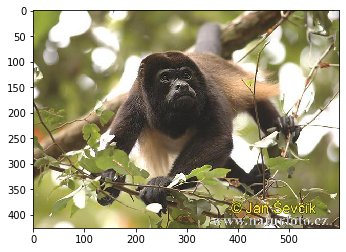

In [15]:
predict_random_monkey()